First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

In [3]:
import time
time.tzname = ('Europe/Vienna', 'Europe/Vienna')

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [4]:
executed_by ='stud-id_12122531'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [5]:
# group id for this project
group_id = '54'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12017130'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12122531'  # Replace the digits after "id_" with student B's student ID

In [6]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [7]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [8]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [9]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [10]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Alexander" .',
f':{student_a} foaf:familyName "Resch" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12017130"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Jakob" .',
f':{student_b} foaf:familyName "Kimeswenger" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12122531"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [11]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## Business Understanding 

In [12]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [13]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
We decided to use the "Corporate Credit Rating with Financial Ratios" dataset available on Kaggle.
The dataset contains a set of financial ratios measuring liquidity, leverage and profitability for multiple companies, together with a corporate credit rating label.
The scenario is a financial institution that wants to assess corporate credit risk based on financial statement information.
The model should assist analysts in assigning credit ratings in decision on creditworthiness.
"""

business_objectives_comment = """
-) Support analysts with consistent credit rating decisions for coporate clients.
-) Identify companies with high credit risk early, to reduce credit losses.
-) Decrease the effort for manual review for low risk companies.
-) At new credit applications, speed up the rating decisions.
"""

business_success_criteria_comment = """
-) Reduce inconsistencies in ratings between analysts by 15 percent.
-) Cut down average review time by 20 percent per company.
-) Keep the share of wrongly accepted high-risk comanies below 10 percent.
-) Avoid blocking of more than 30 percent of low-risk companies.
"""

data_mining_goals_comment = """
-) Train a multi-class classifier that predicts corporate credit ratings from financial ratios.
-) Provide calibrated probability scores to rank companies by risk.
-) Identify the most important financial ratios driving the rating decisions.
-) Support later analysis of class-wise performance for different rating levels.
"""

data_mining_success_criteria_comment = """
-) Achieve a macro-averaged F1 score of at least 0.7 on the test set.
-) Achieve at least a recall of 0.75 for the lowest rating classes.
-) Keep the difference between validation and test F1 below 0.05.
-) Maintain accuracy for all classes rated above 0.60 where sample size is sufficient.
"""

ai_risk_aspects_comment = """
-) Historical ratings can contain human bias, which the model will then learn.
-) Financial ratios behave differently across industries, which can disadvantage some sectors.
-) Wrong predictions for low-rated companies may result in financial losses.
-) Wrong predictions about high-quality companies lead to loss of business and reputational damage.
-) Concept drift can occur because economic conditions change over time.
"""


bu_ass_uuid_executor = "c79bb857-5e80-4d9e-aefb-a4340c7e0caa" # Generate once       
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [15]:
credit_data_path = os.path.join("data", "datasets", "corporate_credit")
load_credit_data_code_writer = student_a
def load_credit_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join(credit_data_path, 'corporate_credit.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)

    raw_data.columns = [
        c.strip()
         .lower()
         .replace(" ", "_")
         .replace("/", "_")
         .replace("-", "_")
        for c in raw_data.columns
    ]
    
    def create_date_index(dataframe: pd.DataFrame):
    # create year, month, and day columns
        index_cols = ['year', 'month', 'day']
        dataframe['rating_date'] = pd.to_datetime(dataframe['rating_date'], format= "%Y-%m-%d", errors="coerce")
        dataframe['year'] = dataframe['rating_date'].dt.year
        dataframe['month'] = dataframe['rating_date'].dt.month
        dataframe['day'] = dataframe['rating_date'].dt.day

        dataframe.sort_values(index_cols, ascending = [True for _ in index_cols], inplace = True)
        dataframe.set_index(index_cols, inplace = True)
        dataframe.index.set_names(index_cols, inplace = True)
        return dataframe

    loaded_data = raw_data.copy()
    loaded_data['day_of_week'] = pd.to_datetime(loaded_data['rating_date']).dt.day_name()
    loaded_data = create_date_index(loaded_data)
    
    return loaded_data

start_time_ld = now()
data = load_credit_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "13a98d44-10e5-48d5-8133-ae1ee123b720" # Generate once
load_credit_data_executor = [
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_credit_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "d646cc42-2512-4712-ad1f-936d4f723f69" # Generate once
ld_report = """
Load the corporate credit rating dataset from CSV, clean column names, parse the rating_date field, and create a hierarchical time index (year, month, day) with an additional day_of_week attribute.
"""
load_credit_data_activity = [
    ':load_credit_data rdf:type prov:Activity .',
    ':load_credit_data sc:isPartOf :data_understanding_phase .',
    ':load_credit_data rdfs:comment \'Data Understanding\' .',
    f':load_credit_data rdfs:comment """{ld_report}""" .', 
    f':load_credit_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_credit_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_credit_data prov:used :raw_data .',
    ':load_credit_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_credit_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_credit_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Corporate credit data set\' .',
    ':raw_data sc:description \'Credit ratings and financial ratios for corporations.\' .',
    # Continue with futher information about the dataset...
    ':corporate_credit_csv rdf:type cr:FileObject .',
    ':corporate_credit_csv sc:name \'corporate_credit.csv\' .',
    ':corporate_credit_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :corporate_credit_csv .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of corporate credit ratings and financial ratios\' .',
    ':raw_recordset cr:source :corporate_credit_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Continue with further information about the recordset...
    ":raw_recordset cr:field :field_rating_date .",
    ":raw_recordset cr:field :field_rating .",
    ":raw_recordset cr:field :field_binary_rating .",
    ":raw_recordset cr:field :field_current_ratio .",
    ":raw_recordset cr:field :field_debt_equity_ratio .",

    #':raw_recordset cr:field :field_date .',
    #':raw_recordset cr:field :field_number .',
    #':field_date rdf:type cr:Field .',
    #':field_date sc:name \'date\' .',
    #':field_date sc:description \'This is a date field of...\' .',
    #':field_date cr:dataType xsd:dateTime .',
    
    # Continue with futher information about the field...
    
    ":field_rating_date rdf:type cr:Field .",
    ":field_rating_date sc:name \'rating_date\' .",
    ":field_rating_date sc:description \'Date at which the credit rating was assigned\' .",
    ":field_rating_date cr:dataType xsd:dateTime .",

    ":field_rating rdf:type cr:Field .",
    ":field_rating sc:name \'rating\' .",
    ":field_rating sc:description \'Long term credit rating symbol (for example AAA, BBB-)\' .",
    ":field_rating cr:dataType xsd:string .",

    ":field_binary_rating rdf:type cr:Field .",
    ":field_binary_rating sc:name \'binary_rating\' .",
    ":field_binary_rating sc:description \'Good vs bad rating indicator\' .",
    ":field_binary_rating cr:dataType xsd:integer .",

    ":field_current_ratio rdf:type cr:Field .",
    ":field_current_ratio sc:name \'current_ratio\' .",
    ":field_current_ratio sc:description \'Current assets divided by current liabilities\' .",
    ":field_current_ratio cr:dataType xsd:double .",

    ":field_debt_equity_ratio rdf:type cr:Field .",
    ":field_debt_equity_ratio sc:name \'debt_equity_ratio\' .",
    ":field_debt_equity_ratio sc:description \'Leverage ratio total debt relative to equity\' .",
    ":field_debt_equity_ratio cr:dataType xsd:double .",
    
    #':field_number rdf:type cr:Field .',
    #':field_number sc:name \'number\' .',
    #':field_number sc:description \'This field describes..\' .',
    #':field_number cr:dataType xsd:integer .',
    # Continue with futher fields...
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    ':recordset rdf:type cr:RecordSet .',
    ':data cr:recordSet :recordset .',

    ":recordset cr:field :field_rating_date .",
    ":recordset cr:field :field_rating .",
    ":recordset cr:field :field_binary_rating .",
    ":recordset cr:field :field_current_ratio .",
    ":recordset cr:field :field_debt_equity_ratio .",
    # The loaded data has additional fields

    ":recordset cr:field :field_day_of_week .",
    ":field_day_of_week rdf:type cr:Field .",
    ":field_day_of_week sc:name \'day_of_week\' .",
    ":field_day_of_week sc:description \'Day of week derived from rating_date\' .",
    ":field_day_of_week cr:dataType xsd:string .",
    
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_current_ratio qudt:unit qudt:UNITLESS .',
    ':field_debt_equity_ratio qudt:unit qudt:UNITLESS .',
]
engine.insert(units_triples, prefixes=prefixes)

rating_agency  \
year month day                                       
2010 4     6    Standard & Poor's Ratings Services   
     5     28   Standard & Poor's Ratings Services   
     6     1    Standard & Poor's Ratings Services   
           16   Standard & Poor's Ratings Services   
           25   Standard & Poor's Ratings Services   

                                   corporation rating rating_date      cik  \
year month day                                                               
2010 4     6             Southern Copper Corp.   BBB-  2010-04-06  1001838   
     5     28                Compass Group PLC   BBB+  2010-05-28  1563190   
     6     1      Fresh Del Monte Produce Inc.      B  2010-06-01  1047340   
           16        Northwest Natural Gas Co.     A-  2010-06-16    73020   
           25   Universal Health Services Inc.    BB+  2010-06-25   352915   

                binary_rating  sic_code sector ticker  current_ratio  ...  \
year month day                                                        ...   
2010 4     6                1    1000.0  Other   SCCO         2.9659  ...   
     5     28               1    7371.0  BusEq   COMP         1.0668  ...   
     6     1                0     100.0  NoDur    FDP         2.5430  ...   
           16               1    4924.0  Utils    NWN         0.8361  ...   
           25               0    8062.0   Hlth    UHS         1.3661  ...   

                pre_tax_profit_margin  net_profit_margin  asset_turnover  \
year month day                                                             
2010 4     6                  37.6092            24.8878          0.6164   
     5     28                 23.1982            15.9279          0.3886   
     6     1                   3.7696             4.1157          1.3468   
           16                 12.0264             7.4179          0.4221   
           25                  9.1251             4.9829          1.3123   

                roe___return_on_equity  return_on_tangible_equity  \
year month day                                                      
2010 4     6                   24.0025                    24.7254   
     5     28                  21.2038                    18.3188   
     6     1                    8.5300                    11.2424   
           16                  11.3803                    11.3803   
           25                  16.9743                    28.7104   

                roa___return_on_assets  roi___return_on_investment  \
year month day                                                       
2010 4     6                   15.4266                     18.0982   
     5     28                   6.5242                     11.8033   
     6     1                    5.5701                      7.1744   
           16                   3.1311                      5.9535   
           25                   7.6744                     11.0683   

                operating_cash_flow_per_share  free_cash_flow_per_share  \
year month day                                                            
2010 4     6                           1.1322                    0.6584   
     5     28                          1.2684                    0.9432   
     6     1                           4.0444                    2.9936   
           16                          9.0433                    3.9589   
           25                          5.5076                    1.6435   

                day_of_week  
year month day               
2010 4     6        Tuesday  
     5     28        Friday  
     6     1        Tuesday  
           16     Wednesday  
           25        Friday  

[5 rows x 26 columns]

## 2a) Attribute types, units, semantics

In [16]:
attr_semantics_code_writer = student_a

attr_semantics_comment = """
Document attribute groups, units, and semantics for the corporate credit dataset.

Financial ratios (liquidity, leverage, profitability, efficiency, growth, cash flow) are dimensionless and express relative quantities.

Absolute quantities such as total assets, total liabilities, revenues, and cash are measured in USD.

rating is an ordered categorical label with classes 0 to 8, where higher values indicate higher credit quality. binary_rating groups low quality (0,1,2) versus all other classes.

rating_date records the decision date and defines the time axis for potential concept drift. Derived calendar attributes (year, month, day, day_of_week) support temporal analysis and checks for seasonality.
"""

start_time_attr = now()
end_time_attr = now()

attr_ass_uuid_executor = "d5f25983-2468-476f-8db5-18b171d21515"
attr_semantics_executor = [
    f':document_attribute_semantics prov:qualifiedAssociation :{attr_ass_uuid_executor} .',
    f':{attr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{attr_ass_uuid_executor} rdf:type prov:Association .',
    f':{attr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(attr_semantics_executor, prefixes=prefixes)

attr_ass_uuid_writer = "73062b36-11c2-4846-ac6e-3a6c0cc943e3"
attr_semantics_activity = [
    ':document_attribute_semantics rdf:type prov:Activity .',
    ':document_attribute_semantics sc:isPartOf :data_understanding_phase .',
    ':document_attribute_semantics rdfs:comment \'Data Understanding\' .',
    f':document_attribute_semantics rdfs:comment """{attr_semantics_comment}""" .',
    f':document_attribute_semantics prov:startedAtTime "{start_time_attr}"^^xsd:dateTime .',
    f':document_attribute_semantics prov:endedAtTime "{end_time_attr}"^^xsd:dateTime .',
    f':document_attribute_semantics prov:qualifiedAssociation :{attr_ass_uuid_writer} .',
    f':{attr_ass_uuid_writer} prov:agent :{attr_semantics_code_writer} .',
    f':{attr_ass_uuid_writer} rdf:type prov:Association .',
    f':{attr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':attribute_semantics_report rdf:type prov:Entity .',
    ':attribute_semantics_report rdfs:label "2a Attribute Types, Units, Semantics" .',
    f':attribute_semantics_report rdfs:comment """{attr_semantics_comment}""" .',
    ':attribute_semantics_report prov:wasGeneratedBy :document_attribute_semantics .',
]
engine.insert(attr_semantics_activity, prefixes=prefixes)

## 2b) Structure of dataset (rows, columns, missing) 

In [17]:
def summarize_structure(data: pd.DataFrame) -> dict:
    summary = {
        "n_rows": int(data.shape[0]),
        "n_columns": int(data.shape[1]),
        "columns": [],
    }

    for col in data.columns:
        col_info = {
            "name": col,
            "dtype": str(data[col].dtype),
            "n_missing": int(data[col].isna().sum()),
            "n_unique": int(data[col].nunique(dropna=True)),
        }
        summary["columns"].append(col_info)

    return summary

start_time_struct = now()
structure_report = summarize_structure(data)
end_time_struct = now()

print(json.dumps(structure_report, indent=2))

#############################################
# Documentation
#############################################

structure_code_writer = student_a
struct_ass_uuid_executor = "b6153ca6-7b27-4aa1-b8a8-399ec3b6706c"
check_structure_executor = [
    f':check_structure prov:qualifiedAssociation :{struct_ass_uuid_executor} .',
    f':{struct_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{struct_ass_uuid_executor} rdf:type prov:Association .',
    f':{struct_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_structure_executor, prefixes=prefixes)

struct_ass_uuid_writer = "845cfade-8aac-47e0-a4c9-b007dca27734"
struct_comment = """
Summarize basic structure of the corporate credit dataset, including number of rows, columns, data types, missing values, and unique values per column.
"""
check_structure_activity = [
    ':check_structure rdf:type prov:Activity .',
    ':check_structure sc:isPartOf :data_understanding_phase .',
    ':check_structure rdfs:comment \'Data Understanding\' .',
    f':check_structure rdfs:comment """{struct_comment}""" .',
    f':check_structure prov:startedAtTime "{start_time_struct}"^^xsd:dateTime .',
    f':check_structure prov:endedAtTime "{end_time_struct}"^^xsd:dateTime .',
    f':check_structure prov:qualifiedAssociation :{struct_ass_uuid_writer} .',
    f':{struct_ass_uuid_writer} prov:agent :{structure_code_writer} .',
    f':{struct_ass_uuid_writer} rdf:type prov:Association .',
    f':{struct_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_structure prov:used :data .',
    ':structure_report rdf:type prov:Entity .',
    ':structure_report rdfs:label "Structure Report" .',
    ':structure_report rdfs:comment """{json.dumps(structure_report, indent=2)}""" .',
    ':structure_report prov:wasGeneratedBy :check_structure .',
]
engine.insert(check_structure_activity, prefixes=prefixes)


{
  "n_rows": 7805,
  "n_columns": 26,
  "columns": [
    {
      "name": "rating_agency",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 7
    },
    {
      "name": "corporation",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 1377
    },
    {
      "name": "rating",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 23
    },
    {
      "name": "rating_date",
      "dtype": "datetime64[ns]",
      "n_missing": 0,
      "n_unique": 1414
    },
    {
      "name": "cik",
      "dtype": "int64",
      "n_missing": 0,
      "n_unique": 686
    },
    {
      "name": "binary_rating",
      "dtype": "int64",
      "n_missing": 0,
      "n_unique": 2
    },
    {
      "name": "sic_code",
      "dtype": "float64",
      "n_missing": 0,
      "n_unique": 240
    },
    {
      "name": "sector",
      "dtype": "object",
      "n_missing": 0,
      "n_unique": 12
    },
    {
      "name": "ticker",
      "dtype": "object",
      "n_missing"

## 2b) Distribution analysis and skewness

In [18]:
def summarize_distributions(
    data: pd.DataFrame,
    numeric_cols,
    categorical_cols,
) -> dict:
    result = {
        "numeric": {},
        "categorical": {},
    }

    for col in numeric_cols:
        series = pd.to_numeric(data[col], errors="coerce")
        desc = series.describe()
        result["numeric"][col] = {
            "count": float(desc["count"]),
            "min": float(desc["min"]),
            "max": float(desc["max"]),
            "mean": float(desc["mean"]),
            "std": float(desc["std"]),
            "median": float(series.median()),
            "skew": float(series.skew()),
        }

    for col in categorical_cols:
        vc = data[col].value_counts(dropna=False)
        top_values = vc.head(5).to_dict()
        result["categorical"][col] = {
            "n_unique": int(vc.shape[0]),
            "top_5": {str(k): int(v) for k, v in top_values.items()},
        }

    return result

numeric_cols = [
    "current_ratio",
    "debt_equity_ratio",
    "gross_margin",
    "operating_margin",
    "asset_turnover",
    "roa___return_on_assets",
    "roe___return_on_equity",
]

categorical_cols = [
    "rating",
    "binary_rating",
    "rating_agency",
    "sector",
]

start_time_dist = now()
distribution_report = summarize_distributions(data, numeric_cols, categorical_cols)
end_time_dist = now()

print(json.dumps(distribution_report, indent=2))


#############################################
# Documentation
#############################################


distribution_code_writer= student_a
dist_ass_uuid_executor = "cac88e6a-97ef-4deb-b476-95e23145e7d4"
check_distribution_executor = [
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_executor} .',
    f':{dist_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dist_ass_uuid_executor} rdf:type prov:Association .',
    f':{dist_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_distribution_executor, prefixes=prefixes)

dist_ass_uuid_writer = "cd9616a1-fa4b-4d0f-b733-87c43bea4442"
dist_comment = """
Analyze distributions and skewness of key financial ratios and inspect the frequency distribution of ratings, binary_rating, rating_agency, and sector.
"""
check_distribution_activity = [
    ':check_distribution rdf:type prov:Activity .',
    ':check_distribution sc:isPartOf :data_understanding_phase .',
    ':check_distribution rdfs:comment \'Data Understanding\' .',
    f':check_distribution rdfs:comment """{dist_comment}""" .',
    f':check_distribution prov:startedAtTime "{start_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:endedAtTime "{end_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_writer} .',
    f':{dist_ass_uuid_writer} prov:agent :{distribution_code_writer} .',
    f':{dist_ass_uuid_writer} rdf:type prov:Association .',
    f':{dist_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_distribution prov:used :data .',
    ':distribution_report rdf:type prov:Entity .',
    ':distribution_report rdfs:comment "Summary of numeric distributions, skewness, and categorical frequency counts for the corporate credit dataset: {json.dumps(distribution_report, indent=2)}" .',
    ':distribution_report prov:wasGeneratedBy :check_distribution .',
]
engine.insert(check_distribution_activity, prefixes=prefixes)


{
  "numeric": {
    "current_ratio": {
      "count": 7805.0,
      "min": 0.1749,
      "max": 34.0768,
      "mean": 1.9263129532351058,
      "std": 1.9216513268251303,
      "median": 1.4968,
      "skew": 7.260350826049169
    },
    "debt_equity_ratio": {
      "count": 7805.0,
      "min": -1473.098,
      "max": 194.375,
      "mean": 0.17734858424087135,
      "std": 34.456334071840175,
      "median": 0.7528,
      "skew": -27.879849890636876
    },
    "gross_margin": {
      "count": 7805.0,
      "min": -87.684,
      "max": 100.0,
      "mean": 42.43390882767457,
      "std": 23.74201988413017,
      "median": 39.6354,
      "skew": 0.3524157289718677
    },
    "operating_margin": {
      "count": 7805.0,
      "min": -461.7878,
      "max": 93.993,
      "mean": 11.53161206918642,
      "std": 25.469044057019673,
      "median": 12.1201,
      "skew": -9.75432422576551
    },
    "asset_turnover": {
      "count": 7805.0,
      "min": 0.0684,
      "max": 8.5039,
     

## 2b) Correlation Analysis

In [19]:
correlation_code_writer = student_a

start_time_corr = now()
numeric_cols_corr = data.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = data[numeric_cols_corr].corr()
end_time_corr = now()

print("Correlation matrix for numerical attributes:")
print(correlation_matrix)

#############################################
# Documentation
#############################################

correlation_comment = """
Compute pairwise Pearson correlations for numerical attributes.
Strong absolute correlations above 0.7 or below -0.7 indicate multicollinearity
and redundant information. These findings influence feature selection and model design.
"""

corr_ass_uuid_executor = "39026d2f-0d4b-4de5-8869-a013c57b676d"
correlation_executor_triples = [
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_executor} .',
    f':{corr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{corr_ass_uuid_executor} rdf:type prov:Association .',
    f':{corr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(correlation_executor_triples, prefixes=prefixes)

corr_ass_uuid_writer = "a7679dfe-0b2d-4c46-8f62-e36f273d3f08"
correlation_activity = [
    ':correlation_analysis rdf:type prov:Activity .',
    ':correlation_analysis sc:isPartOf :data_understanding_phase .',
    ':correlation_analysis rdfs:comment \'Data Understanding\' .',
    f':correlation_analysis rdfs:comment """{correlation_comment}""" .',
    f':correlation_analysis prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':correlation_analysis prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    ':correlation_analysis prov:used :data .',
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{correlation_code_writer} .',
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':correlation_report rdf:type prov:Entity .',
    ':correlation_report rdfs:label "Correlation Matrix Report" .',
    f':correlation_report rdfs:comment """{correlation_matrix.to_csv()}""" .',
    ':correlation_report prov:wasGeneratedBy :correlation_analysis .',
]
engine.insert(correlation_activity, prefixes=prefixes)


Correlation matrix for numerical attributes:
                                    cik  binary_rating  sic_code  \
cik                            1.000000      -0.197267  0.074902   
binary_rating                 -0.197267       1.000000 -0.037041   
sic_code                       0.074902      -0.037041  1.000000   
current_ratio                  0.007580      -0.161645 -0.200719   
long_term_debt___capital       0.014873      -0.031988  0.011567   
debt_equity_ratio             -0.005612       0.015706 -0.007423   
gross_margin                  -0.000658       0.150972  0.071422   
operating_margin              -0.003527       0.201165  0.118917   
ebit_margin                   -0.003064       0.202285  0.117415   
ebitda_margin                  0.015711       0.158042  0.085685   
pre_tax_profit_margin         -0.029533       0.224077  0.109921   
net_profit_margin             -0.044452       0.207499  0.107298   
asset_turnover                 0.014506       0.004372  0.070675   
roe

## 2c) Outlier detection

In [20]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=()) -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING
    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx]),
                'value': float(values.loc[idx]), 
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results

outlier_cols = [
    "current_ratio",
    "debt_equity_ratio",
    "gross_margin",
    "operating_margin",
    "roa___return_on_assets",
    "roe___return_on_equity",
]

start_time_co = now()
outliers_report = check_outliers(data, threshold=3.0, columns = outlier_cols)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

outlier_summary = {col: len(lst) for col, lst in outliers_report.items()}
print(outlier_summary)

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "95206ddb-90c8-49c4-bfe8-885fcbd78a41"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "2715863d-e3af-4688-8a9f-98ed9ee3b616"
co_comment = """
Identify potential outliers in key financial ratios using a z-score based approach. Ratios with an absolute z-score larger than 3.0 are flagged as outliers.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "21fe4859-e560-4800-82aa-9aa88923794d"
ior_comment = """
After inspecting the report, the decision is to cap extreme leverage and profitability ratios in the preparation phase instead of dropping rows, to keep as much data as possible.
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Cap extreme ratio values in the data preparation phase instead of removing rows.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

{'current_ratio': [{'index': 31, 'z_score': 3.119341663645297, 'value': 7.9206}, {'index': 143, 'z_score': 16.73065586767114, 'value': 34.0768}, {'index': 236, 'z_score': 3.32957751359393, 'value': 8.3246}, {'index': 257, 'z_score': 3.32957751359393, 'value': 8.3246}, {'index': 328, 'z_score': 3.3453452023400776, 'value': 8.3549}, {'index': 481, 'z_score': 3.2296634462916094, 'value': 8.1326}, {'index': 585, 'z_score': 3.3453452023400776, 'value': 8.3549}, {'index': 606, 'z_score': 12.489303710687624, 'value': 25.9264}, {'index': 782, 'z_score': 3.804845834777313, 'value': 9.2379}, {'index': 850, 'z_score': 10.723842956886305, 'value': 22.5338}, {'index': 851, 'z_score': 4.358328136770794, 'value': 10.3015}, {'index': 869, 'z_score': 10.723842956886305, 'value': 22.5338}, {'index': 1006, 'z_score': 12.489303710687624, 'value': 25.9264}, {'index': 1027, 'z_score': 12.489303710687624, 'value': 25.9264}, {'index': 1028, 'z_score': 12.489303710687624, 'value': 25.9264}, {'index': 1129, 'z_

## 2c) Plausibility check

In [21]:
def check_plausibility(data: pd.DataFrame) -> dict:
    checks = {}

    checks["current_ratio_negative"] = int((data["current_ratio"] < 0).sum())

    checks["gross_margin_outside_-100_100"] = int(
        ((data["gross_margin"] < -100) | (data["gross_margin"] > 100)).sum()
    )
    checks["operating_margin_outside_-100_100"] = int(
        ((data["operating_margin"] < -100) | (data["operating_margin"] > 100)).sum()
    )

    checks["roa_below_-100"] = int((data["roa___return_on_assets"] < -100).sum())
    checks["roa_above_100"] = int((data["roa___return_on_assets"] > 100).sum())

    checks["roe_below_-1000"] = int((data["roe___return_on_equity"] < -1000).sum())
    checks["roe_above_1000"] = int((data["roe___return_on_equity"] > 1000).sum())

    return checks

start_time_pl = now()
plausibility_report = check_plausibility(data)
end_time_pl = now()

print(json.dumps(plausibility_report, indent=2))

#############################################
# Documentation
#############################################

plausibility_code_writer = student_a
pl_ass_uuid_executor = "eb91b640-5d83-41ee-9b6d-5de8c7b12b9b"
check_plausibility_executor = [
    f':check_plausibility prov:qualifiedAssociation :{pl_ass_uuid_executor} .',
    f':{pl_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{pl_ass_uuid_executor} rdf:type prov:Association .',
    f':{pl_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_plausibility_executor, prefixes=prefixes)

pl_ass_uuid_writer = "18de5079-8470-4cc1-8fd9-d0dd44046dca"
pl_comment = """
Check the plausibility of key financial ratios by counting values with clearly unrealistic ranges, for example extreme negative or positive liquidity and profitability ratios.
"""
check_plausibility_activity = [
    ':check_plausibility rdf:type prov:Activity .',
    ':check_plausibility sc:isPartOf :data_understanding_phase .',
    ':check_plausibility rdfs:comment \'Data Understanding\' .',
    f':check_plausibility rdfs:comment """{pl_comment}""" .',
    f':check_plausibility prov:startedAtTime "{start_time_pl}"^^xsd:dateTime .',
    f':check_plausibility prov:endedAtTime "{end_time_pl}"^^xsd:dateTime .',
    f':check_plausibility prov:qualifiedAssociation :{pl_ass_uuid_writer} .',
    f':{pl_ass_uuid_writer} prov:agent :{plausibility_code_writer} .',
    f':{pl_ass_uuid_writer} rdf:type prov:Association .',
    f':{pl_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_plausibility prov:used :data .',
    ':plausibility_report rdf:type prov:Entity .',
    ':plausibility_report rdfs:label "Plausibility Report" .',
    ':plausibility_report rdfs:comment "Summary of plausibility checks for financial ratios in the corporate credit dataset: {json.dumps(plausibility_report, indent=2)}" .',
    ':plausibility_report prov:wasGeneratedBy :check_plausibility .',
]
engine.insert(check_plausibility_activity, prefixes=prefixes)



{
  "current_ratio_negative": 0,
  "gross_margin_outside_-100_100": 0,
  "operating_margin_outside_-100_100": 56,
  "roa_below_-100": 4,
  "roa_above_100": 4,
  "roe_below_-1000": 11,
  "roe_above_1000": 20
}


## 2d) Visual exploration of key variables

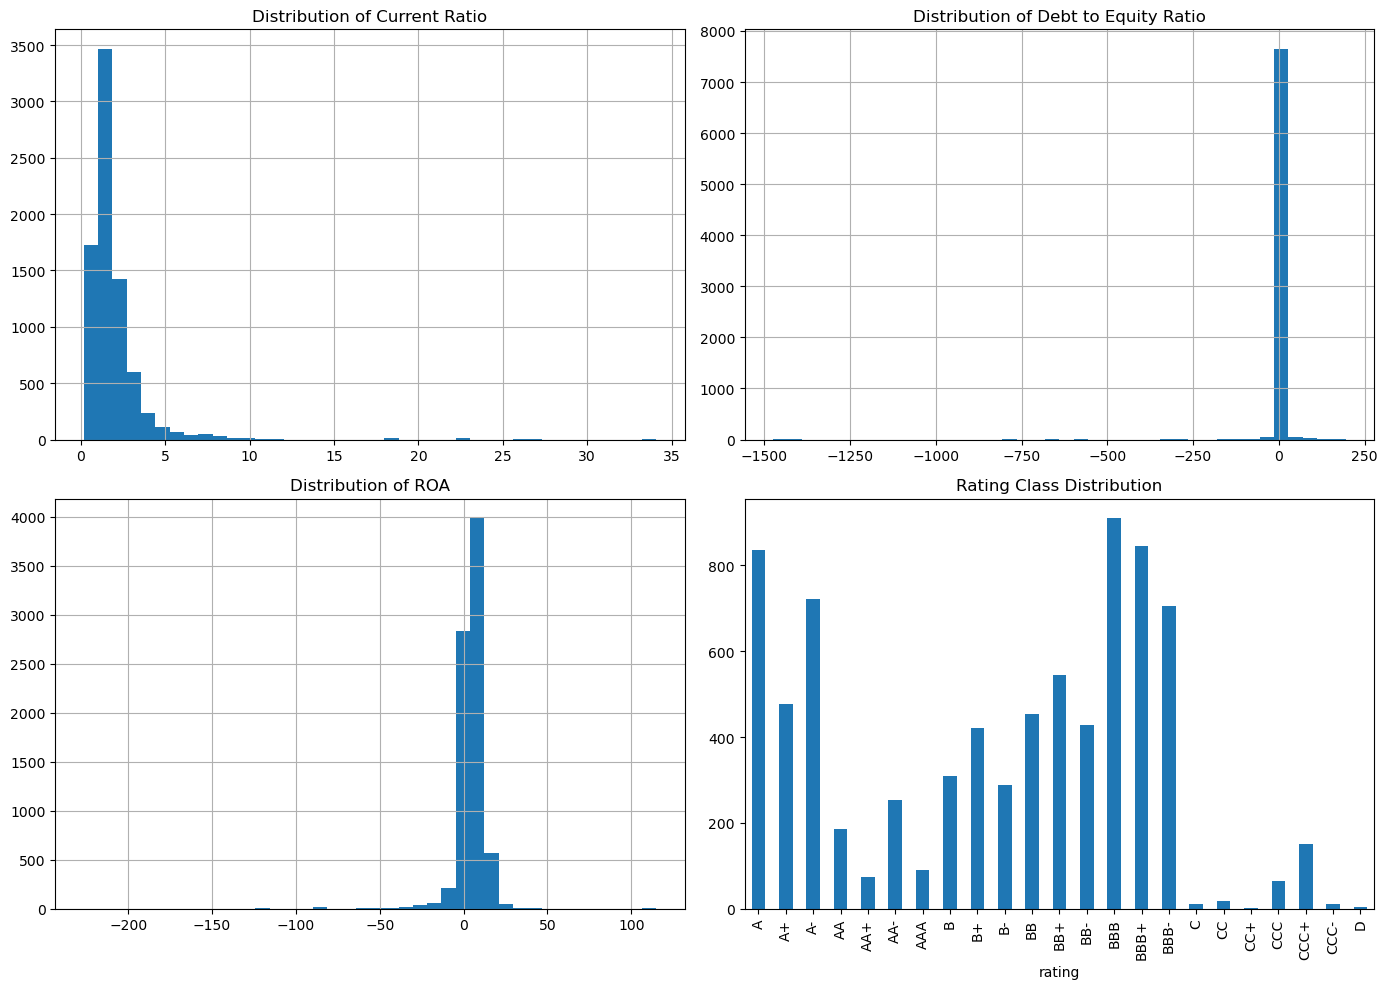

In [22]:
visual_code_writer = student_a

import matplotlib.pyplot as plt

start_time_vis = now()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

if "current_ratio" in data.columns:
    data["current_ratio"].hist(ax=axs[0, 0], bins=40)
    axs[0, 0].set_title("Distribution of Current Ratio")

if "debt_equity_ratio" in data.columns:
    data["debt_equity_ratio"].hist(ax=axs[0, 1], bins=40)
    axs[0, 1].set_title("Distribution of Debt to Equity Ratio")

if "roa___return_on_assets" in data.columns:
    data["roa___return_on_assets"].hist(ax=axs[1, 0], bins=40)
    axs[1, 0].set_title("Distribution of ROA")

if "rating" in data.columns:
    data["rating"].value_counts().sort_index().plot(kind="bar", ax=axs[1, 1])
    axs[1, 1].set_title("Rating Class Distribution")

plt.tight_layout()
plt.show()

end_time_vis = now()

#############################################
# Documentation
#############################################

visual_comment = """
Produce histograms for selected financial ratios and a bar chart for rating classes.
The plots show skewed distributions, long tails, and strong class imbalance.
These observations support later decisions on outlier handling, transformation,
and class weighting strategies.
"""

vis_ass_uuid_executor = "bbeb7ab9-c9f1-4b99-a248-212b9bfc7ae7"
visual_executor_triples = [
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_executor} .',
    f':{vis_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{vis_ass_uuid_executor} rdf:type prov:Association .',
    f':{vis_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(visual_executor_triples, prefixes=prefixes)

vis_ass_uuid_writer = "64c6a0ef-5ce3-4ad0-9efb-342b5a03c900"
visual_activity = [
    ':visual_exploration rdf:type prov:Activity .',
    ':visual_exploration sc:isPartOf :data_understanding_phase .',
    ':visual_exploration rdfs:comment \'Data Understanding\' .',
    f':visual_exploration rdfs:comment """{visual_comment}""" .',
    f':visual_exploration prov:startedAtTime "{start_time_vis}"^^xsd:dateTime .',
    f':visual_exploration prov:endedAtTime "{end_time_vis}"^^xsd:dateTime .',
    ':visual_exploration prov:used :data .',
    f':visual_exploration prov:qualifiedAssociation :{vis_ass_uuid_writer} .',
    f':{vis_ass_uuid_writer} prov:agent :{visual_code_writer} .',
    f':{vis_ass_uuid_writer} rdf:type prov:Association .',
    f':{vis_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':visual_exploration_report rdf:type prov:Entity .',
    ':visual_exploration_report rdfs:label "Visual Exploration Summary" .',
    ':visual_exploration_report rdfs:comment """Histograms for key ratios and rating distribution plotted for data understanding.""" .',
    ':visual_exploration_report prov:wasGeneratedBy :visual_exploration .',
]
engine.insert(visual_activity, prefixes=prefixes)

## 2e) Sensitive attributes and minority groups

In [23]:
sensitive_code_writer = student_a

sensitive_comment = """
The dataset does not contain explicit sensitive attributes such as gender or ethnicity. Minority groups appear in rare target classes, especially rating classes 0 and 1. These classes have few observations and need attention in evaluation and model design, for example through class weights or sampling strategies.
"""

start_time_sens = now()
end_time_sens = now()

sensitive_ass_uuid_executor = "eee58b3c-59ac-4f30-be56-e51564c13b29"
sensitive_executor_triples = [
    f':document_sensitive_attributes prov:qualifiedAssociation :{sensitive_ass_uuid_executor} .',
    f':{sensitive_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{sensitive_ass_uuid_executor} rdf:type prov:Association .',
    f':{sensitive_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(sensitive_executor_triples, prefixes=prefixes)

sensitive_ass_uuid_writer = "04896b6f-8691-498d-ab9d-08a0a5248604"
sensitive_activity = [
    ':document_sensitive_attributes rdf:type prov:Activity .',
    ':document_sensitive_attributes sc:isPartOf :data_understanding_phase .',
    ':document_sensitive_attributes rdfs:comment \'Data Understanding\' .',
    f':document_sensitive_attributes rdfs:comment """{sensitive_comment}""" .',
    f':document_sensitive_attributes prov:startedAtTime "{start_time_sens}"^^xsd:dateTime .',
    f':document_sensitive_attributes prov:endedAtTime "{end_time_sens}"^^xsd:dateTime .',
    f':document_sensitive_attributes prov:qualifiedAssociation :{sensitive_ass_uuid_writer} .',
    f':{sensitive_ass_uuid_writer} prov:agent :{sensitive_code_writer} .',
    f':{sensitive_ass_uuid_writer} rdf:type prov:Association .',
    f':{sensitive_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':sensitive_attributes_report rdf:type prov:Entity .',
    ':sensitive_attributes_report rdfs:label "2e Sensitive Attributes and Minority Groups" .',
    f':sensitive_attributes_report rdfs:comment """{sensitive_comment}""" .',
    ':sensitive_attributes_report prov:wasGeneratedBy :document_sensitive_attributes .',
]
engine.insert(sensitive_activity, prefixes=prefixes)


## 2f) Risks and bias in the data

In [24]:
bias_code_writer = student_a

bias_comment = """
Historical ratings reflect past human judgment and internal policies. This creates systematic bias in the target labels. Missing sector information hides structural differences between industries and firm sizes.

rating_date spans multiple years, so changes in the economic cycle and internal rating guidelines influence label stability and calibration.

Open questions for a domain expert:
1) Did rating guidelines change during the covered period.
2) Are some industries overrepresented in the dataset.
3) Are financial ratios comparable across firm sizes for all rating classes.
"""

start_time_bias = now()
end_time_bias = now()

bias_ass_uuid_executor = "46aa277a-34f3-4eba-86b3-f167be971cad"
bias_executor_triples = [
    f':document_bias_risks prov:qualifiedAssociation :{bias_ass_uuid_executor} .',
    f':{bias_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bias_ass_uuid_executor} rdf:type prov:Association .',
    f':{bias_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(bias_executor_triples, prefixes=prefixes)

bias_ass_uuid_writer = "881a1f63-3710-48a8-ac0a-61a5f9bf5869"
bias_activity = [
    ':document_bias_risks rdf:type prov:Activity .',
    ':document_bias_risks sc:isPartOf :data_understanding_phase .',
    ':document_bias_risks rdfs:comment \'Data Understanding\' .',
    f':document_bias_risks rdfs:comment """{bias_comment}""" .',
    f':document_bias_risks prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':document_bias_risks prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    f':document_bias_risks prov:qualifiedAssociation :{bias_ass_uuid_writer} .',
    f':{bias_ass_uuid_writer} prov:agent :{bias_code_writer} .',
    f':{bias_ass_uuid_writer} rdf:type prov:Association .',
    f':{bias_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':bias_risks_report rdf:type prov:Entity .',
    ':bias_risks_report rdfs:label "2f Risks and Bias in Data" .',
    f':bias_risks_report rdfs:comment """{bias_comment}""" .',
    ':bias_risks_report prov:wasGeneratedBy :document_bias_risks .',
]
engine.insert(bias_activity, prefixes=prefixes)


## 2g) Planned actions for data preparation

In [25]:
prep_code_writer = student_a

prep_comment = """
Planned preparation actions based on the data understanding findings:

1) Cap extreme outliers in leverage, liquidity, and profitability ratios instead of dropping rows, to keep more observations.
2) Apply suitable strategies for missing values, for example dropping rows with many missing entries and imputing single missing ratios.
3) Encode rating as ordinal target and keep binary_rating as helper target for alternative evaluation.
4) Address class imbalance with stratified splits and class weights during model training.
5) Normalize or transform strongly skewed ratios, for example with log transforms for strictly positive variables.
"""

start_time_prep = now()
end_time_prep = now()

prep_ass_uuid_executor = "beeb3651-2154-48d7-b616-1f040c8deb56"
prep_executor_triples = [
    f':document_preparation_actions prov:qualifiedAssociation :{prep_ass_uuid_executor} .',
    f':{prep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{prep_ass_uuid_executor} rdf:type prov:Association .',
    f':{prep_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(prep_executor_triples, prefixes=prefixes)

prep_ass_uuid_writer = "bfc079c5-0dbe-477c-b1cd-56f85f8dcbf8"
prep_activity = [
    ':document_preparation_actions rdf:type prov:Activity .',
    ':document_preparation_actions sc:isPartOf :data_understanding_phase .',
    ':document_preparation_actions rdfs:comment \'Data Understanding\' .',
    f':document_preparation_actions rdfs:comment """{prep_comment}""" .',
    f':document_preparation_actions prov:startedAtTime "{start_time_prep}"^^xsd:dateTime .',
    f':document_preparation_actions prov:endedAtTime "{end_time_prep}"^^xsd:dateTime .',
    f':document_preparation_actions prov:qualifiedAssociation :{prep_ass_uuid_writer} .',
    f':{prep_ass_uuid_writer} prov:agent :{prep_code_writer} .',
    f':{prep_ass_uuid_writer} rdf:type prov:Association .',
    f':{prep_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':preparation_actions_report rdf:type prov:Entity .',
    ':preparation_actions_report rdfs:label "2g Planned Data Preparation Actions" .',
    f':preparation_actions_report rdfs:comment """{prep_comment}""" .',
    ':preparation_actions_report prov:wasGeneratedBy :document_preparation_actions .',
]
engine.insert(prep_activity, prefixes=prefixes)


## Data Preparation

In [26]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [27]:
handle_outliers_code_writer = student_b

def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    threshold = 3.0 # three-sigma rule
    df_clean = df.copy()

    for col, outliers in outliers_report.items():
        if col not in df_clean.columns or len(outliers) == 0:
            continue

        values = df_clean[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            continue

        upper_cap = mean + threshold * std
        lower_cap = mean - threshold * std

        for o in outliers:
            pos = o["index"]  # positional index

            val = df_clean.iloc[pos, df_clean.columns.get_loc(col)]

            if val > upper_cap:
                df_clean.iloc[pos, df_clean.columns.get_loc(col)] = upper_cap
            elif val < lower_cap:
                df_clean.iloc[pos, df_clean.columns.get_loc(col)] = lower_cap

    return df_clean

start_time_td = now()
cleaned_data = handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
During the outlier handling phase, extreme values that were identified in the Data Understanding phase 
were addressed in order to reduce their influence on the analysis. Instead of removing entire observations, 
these outliers were treated so that more data points could be retained while still improving the overall 
quality and stability of the dataset.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [28]:
handle_missing_values_code_writer = student_b
def handle_missing_values(
    df: pd.DataFrame,
    ratio_columns: list,
    row_missing_threshold: float = 0.4,
    col_missing_threshold: float = 0.5,
) -> pd.DataFrame:
    """
    Handles missing values by:
    1) Dropping rows with too many missing values
    2) Imputing single missing ratio values using the median
    """

    df_clean = df.copy()

    # --------------------------------------------------
    # 1) Drop rows with excessive missing values
    # --------------------------------------------------
    row_missing_share = df_clean.isna().mean(axis=1)
    df_clean = df_clean.loc[row_missing_share <= row_missing_threshold].copy()

    # --------------------------------------------------
    # 2) Impute ratio columns with limited missingness
    # --------------------------------------------------
    for col in ratio_columns:
        if col not in df_clean.columns:
            continue

        missing_share = df_clean[col].isna().mean()

        # Skip columns with too many missing values
        if missing_share == 0 or missing_share > col_missing_threshold:
            continue

        median_value = df_clean[col].median()

        if not np.isnan(median_value):
            df_clean[col] = df_clean[col].fillna(median_value)

    return df_clean
# colums that are finacial ratios and should be filled by mean if empty    
ratio_columns = [
    "Current Ratio",
    "Long-term Debt / Capital",
    "Debt/Equity Ratio",
    "Gross Margin",
    "Operating Margin",
    "EBIT Margin",
    "EBITDA Margin",
    "Pre-Tax Profit Margin",
    "Net Profit Margin",
    "Asset Turnover",
    "ROE - Return On Equity",
    "Return On Tangible Equity",
    "ROA - Return On Assets",
    "ROI - Return On Investment",
    "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share",
]
start_time_mv = now()
cleaned_data = handle_missing_values(cleaned_data, ratio_columns)
end_time_mv = now()

mv_ass_uuid_executor = "ec7e81e1-86ea-475a-b9z5-c7d8ee535488"
handle_missing_values_executor = [
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_missing_values_executor, prefixes=prefixes)

mv_ass_uuid_writer = "1405f15a-3545-6789-a962-637b3c10a137"
mv_comment = """
In the missing value handling step, observations with a high proportion of missing data were removed to ensure data reliability, 
while isolated missing values in financial ratio variables were imputed using robust column medians. Non-ratio variables were 
excluded from imputation.
"""
handle_missing_values_activity = [
    ':handle_missing_values rdf:type prov:Activity .',
    ':handle_missing_values sc:isPartOf :data_preparation_phase .',
    ':handle_missing_values rdfs:comment \'Data Preparation\' .', 
    f':handle_missing_values rdfs:comment """{mv_comment}""" .', 
    f':handle_missing_values prov:startedAtTime "{start_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:endedAtTime "{end_time_mv}"^^xsd:dateTime .',
    f':handle_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{handle_missing_values_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_missing_values prov:used :data .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_missing_values .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_missing_values_activity, prefixes=prefixes)

In [29]:
#3) Encode rating as ordinal target.
encode_rating_code_writer = student_b

def encode_rating(
    df: pd.DataFrame,
    rating_col: str = "rating",
) -> pd.DataFrame:

    df_encoded = df.copy()

    rating_order = [
        "AAA",
        "AA+", "AA", "AA-",
        "A+", "A", "A-",
        "BBB+", "BBB", "BBB-",
        "BB+", "BB", "BB-",
        "B+", "B", "B-",
        "CCC+", "CCC", "CCC-",
        "D"
    ]

    rating_map = {rating: i + 1 for i, rating in enumerate(rating_order)}

    df_encoded[rating_col] = df_encoded[rating_col].map(rating_map)

    return df_encoded
    
start_time_er = now()
cleaned_data = encode_rating(cleaned_data)
end_time_er = now()

er_ass_uuid_executor = "ec7e81e1-86ea-123b-b9z5-c7d8ee535488"
encode_rating_executor = [
    f':encode_rating prov:qualifiedAssociation :{er_ass_uuid_executor} .',
    f':{er_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{er_ass_uuid_executor} rdf:type prov:Association .',
    f':{er_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(encode_rating_executor, prefixes=prefixes)

er_ass_uuid_writer = "1405f15a-1234-6789-a963-637b3c10a137"
er_comment = """
In this step, the credit rating variable was transformed into an ordinal numeric scale to reflect the natural ordering 
of credit quality from higher to lower ratings. This makes the rating variable easier to use in the modeling process, 
while still preserving the relative differences between rating categories. In addition, the binary rating variable was 
kept unchanged and used as a supporting target for alternative evaluation and comparison of model results.
"""
encode_rating_activity = [
    ':encode_rating rdf:type prov:Activity .',
    ':encode_rating sc:isPartOf :data_preparation_phase .',
    ':encode_rating rdfs:comment \'Data Preparation\' .', 
    f':encode_rating rdfs:comment """{er_comment}""" .', 
    f':encode_rating prov:startedAtTime "{start_time_er}"^^xsd:dateTime .',
    f':encode_rating prov:endedAtTime "{end_time_er}"^^xsd:dateTime .',
    f':encode_rating prov:qualifiedAssociation :{er_ass_uuid_writer} .',
    f':{er_ass_uuid_writer} prov:agent :{encode_rating_code_writer} .',
    f':{er_ass_uuid_writer} rdf:type prov:Association .',
    f':{er_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':encode_rating prov:used :data .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :encode_rating .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(encode_rating_activity, prefixes=prefixes)

In [30]:
from sklearn.preprocessing import StandardScaler

scale_features_code_writer = student_b
def scale_features(
    df: pd.DataFrame,
    feature_columns: list
) -> pd.DataFrame:
    
    df_scaled = df.copy()

    scaler = StandardScaler()
    df_scaled[feature_columns] = scaler.fit_transform(
        df_scaled[feature_columns]
    )

    return df_scaled

scale_columns = [
    "current_ratio",
    "debt_equity_ratio",
    "long_term_debt___capital",
    "gross_margin",
    "operating_margin",
    "ebit_margin",
    "ebitda_margin",
    "pre_tax_profit_margin",
    "net_profit_margin",
    "asset_turnover",
    "roa___return_on_assets",
    "roe___return_on_equity",
    "return_on_tangible_equity",
    "roi___return_on_investment",
    "operating_cash_flow_per_share",
    "free_cash_flow_per_share",
]

start_time_sf = now()
cleaned_data = scale_features(cleaned_data, scale_columns)
end_time_sf = now()

sf_ass_uuid_executor = "ec7e81e1-86ea-345z-b9z5-c7d8ab785488"
scale_features_executor = [
    f':scale_features prov:qualifiedAssociation :{sf_ass_uuid_executor} .',
    f':{sf_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{sf_ass_uuid_executor} rdf:type prov:Association .',
    f':{sf_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(scale_features_executor, prefixes=prefixes)

sf_ass_uuid_writer = "1405f15a-5678-1111-a963-637a3z10a167"
sf_comment = """
The numerical ratio variables were scaled so that they are on a similar scale and no single variable dominates the model.
"""
scale_features_activity = [
    ':scale_features rdf:type prov:Activity .',
    ':scale_features sc:isPartOf :data_preparation_phase .',
    ':scale_features rdfs:comment \'Data Preparation\' .', 
    f':scale_features rdfs:comment """{sf_comment}""" .', 
    f':scale_features prov:startedAtTime "{start_time_sf}"^^xsd:dateTime .',
    f':scale_features prov:endedAtTime "{end_time_sf}"^^xsd:dateTime .',
    f':scale_features prov:qualifiedAssociation :{sf_ass_uuid_writer} .',
    f':{sf_ass_uuid_writer} prov:agent :{scale_features_code_writer} .',
    f':{sf_ass_uuid_writer} rdf:type prov:Association .',
    f':{sf_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':scale_features prov:used :data .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :encode_rating .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(scale_features_activity, prefixes=prefixes)

In [31]:
not_used_code_writer = student_b

start_time_nd = now()
nd_comment = """
Binning was not applied to the financial ratio variables. Although binning can simplify continuous variables 
by grouping them into categories, it also leads to a loss of information. In this dataset, the ratios contain 
meaningful continuous variation that is important for modeling credit risk. Since outliers were already handled 
and the models used can work well with continuous variables, keeping the original ratio values was considered 
more appropriate than applying binning.

Additional transformations of numerical variables, such as logarithmic or power transformations, were considered to 
address skewed distributions. These transformations were not applied because several financial ratios contain zero or 
negative values, and applying a uniform transformation could distort the original economic meaning of the variables. 
After handling outliers, the remaining distributions were considered acceptable for further analysis.

Feature scaling was considered to bring numerical variables onto a comparable scale. This step was not applied at this 
stage, as the decision depends on the final choice of modeling approach. Scaling can be applied later if required by the 
selected model, but was not enforced during the data preparation phase.

The removal of attributes was considered to reduce dimensionality and remove potentially redundant information. However,
all remaining variables were deemed relevant either as financial indicators, identifiers, or target variables. Therefore, 
no attributes were removed during data preparation.

"""
end_time_nd = now()

nd_ass_uuid_executor = "ec6k81b1-12ab-345z-b9z5-c7d8ab796488"
not_used_executor = [
    f':scale_features prov:qualifiedAssociation :{nd_ass_uuid_executor} .',
    f':{nd_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{nd_ass_uuid_executor} rdf:type prov:Association .',
    f':{nd_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(not_used_executor, prefixes=prefixes)

nd_ass_uuid_writer = "1504f11a-5678-1221-a913-343a3z10l167"

not_used_activity = [
    ':not_used rdf:type prov:Activity .',
    ':not_used sc:isPartOf :data_preparation_phase .',
    ':not_used rdfs:comment \'Data Preparation\' .', 
    f':not_used rdfs:comment """{nd_comment}""" .', 
    f':not_used prov:startedAtTime "{start_time_nd}"^^xsd:dateTime .',
    f':not_used prov:endedAtTime "{end_time_nd}"^^xsd:dateTime .',
    f':not_used prov:qualifiedAssociation :{nd_ass_uuid_writer} .',
    f':{nd_ass_uuid_writer} prov:agent :{not_used_code_writer} .',
    f':{nd_ass_uuid_writer} rdf:type prov:Association .',
    f':{nd_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]
engine.insert(not_used_activity, prefixes=prefixes)

In [32]:
derived_attributes_code_writer = student_b

start_time_da = now()
da_comment = """
The possibility of creating additional derived attributes was considered, such as combining financial ratios or 
creating summary indicators for liquidity, leverage, or profitability. While these derived features could potentially 
capture more complex relationships in the data, they were not created at this stage. The original financial ratios already 
provide sufficient information, and adding derived attributes would increase complexity without big benefits for the current analysis.
"""
end_time_da = now()

da_ass_uuid_executor = "uz6k81b1-12gf-345z-b9z5-c7d8ab123488"
derived_attributes_executor = [
    f':derived_attributes prov:qualifiedAssociation :{da_ass_uuid_executor} .',
    f':{da_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{da_ass_uuid_executor} rdf:type prov:Association .',
    f':{da_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(derived_attributes_executor, prefixes=prefixes)

da_ass_uuid_writer = "8464s11a-5678-1221-a913-343y3z10l167"

derived_attributes_activity = [
    ':derived_attributes rdf:type prov:Activity .',
    ':derived_attributes sc:isPartOf :data_preparation_phase .',
    ':derived_attributes rdfs:comment \'Data Preparation\' .', 
    f':derived_attributes rdfs:comment """{da_comment}""" .', 
    f':derived_attributes prov:startedAtTime "{start_time_da}"^^xsd:dateTime .',
    f':derived_attributes prov:endedAtTime "{end_time_da}"^^xsd:dateTime .',
    f':derived_attributes prov:qualifiedAssociation :{da_ass_uuid_writer} .',
    f':{da_ass_uuid_writer} prov:agent :{derived_attributes_code_writer} .',
    f':{da_ass_uuid_writer} rdf:type prov:Association .',
    f':{da_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]
engine.insert(derived_attributes_activity, prefixes=prefixes)

In [33]:
external_data_sources_code_writer = student_b

start_time_ed = now()
ed_comment = """
The use of additional external data sources was considered to improve the prediction of corporate credit risk. 
Possible external attributes include macroeconomic indicators such as interest rates or economic growth, as well as 
industry-level information to capture differences between sectors. Market-based data like stock price volatility could 
also provide useful information. These data sources were not included in this analysis and could be explored in future work.
"""
end_time_ed = now()

ed_ass_uuid_executor = "uz6k81b1-12gf-098z-b9c5-c7d8iu123488"
external_data_sourcess_executor = [
    f':external_data_sources prov:qualifiedAssociation :{ed_ass_uuid_executor} .',
    f':{ed_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ed_ass_uuid_executor} rdf:type prov:Association .',
    f':{ed_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(external_data_sourcess_executor, prefixes=prefixes)

ed_ass_uuid_writer = "8906s12a-5678-1881-a913-343y3v10l167"

external_data_sources_activity = [
    ':external_data_sources rdf:type prov:Activity .',
    ':external_data_sources sc:isPartOf :data_preparation_phase .',
    ':external_data_sources rdfs:comment \'Data Preparation\' .', 
    f':external_data_sources rdfs:comment """{ed_comment}""" .', 
    f':external_data_sources prov:startedAtTime "{start_time_ed}"^^xsd:dateTime .',
    f':external_data_sources prov:endedAtTime "{end_time_ed}"^^xsd:dateTime .',
    f':external_data_sources prov:qualifiedAssociation :{ed_ass_uuid_writer} .',
    f':{ed_ass_uuid_writer} prov:agent :{external_data_sources_code_writer} .',
    f':{ed_ass_uuid_writer} rdf:type prov:Association .',
    f':{ed_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
]
engine.insert(external_data_sources_activity, prefixes=prefixes)

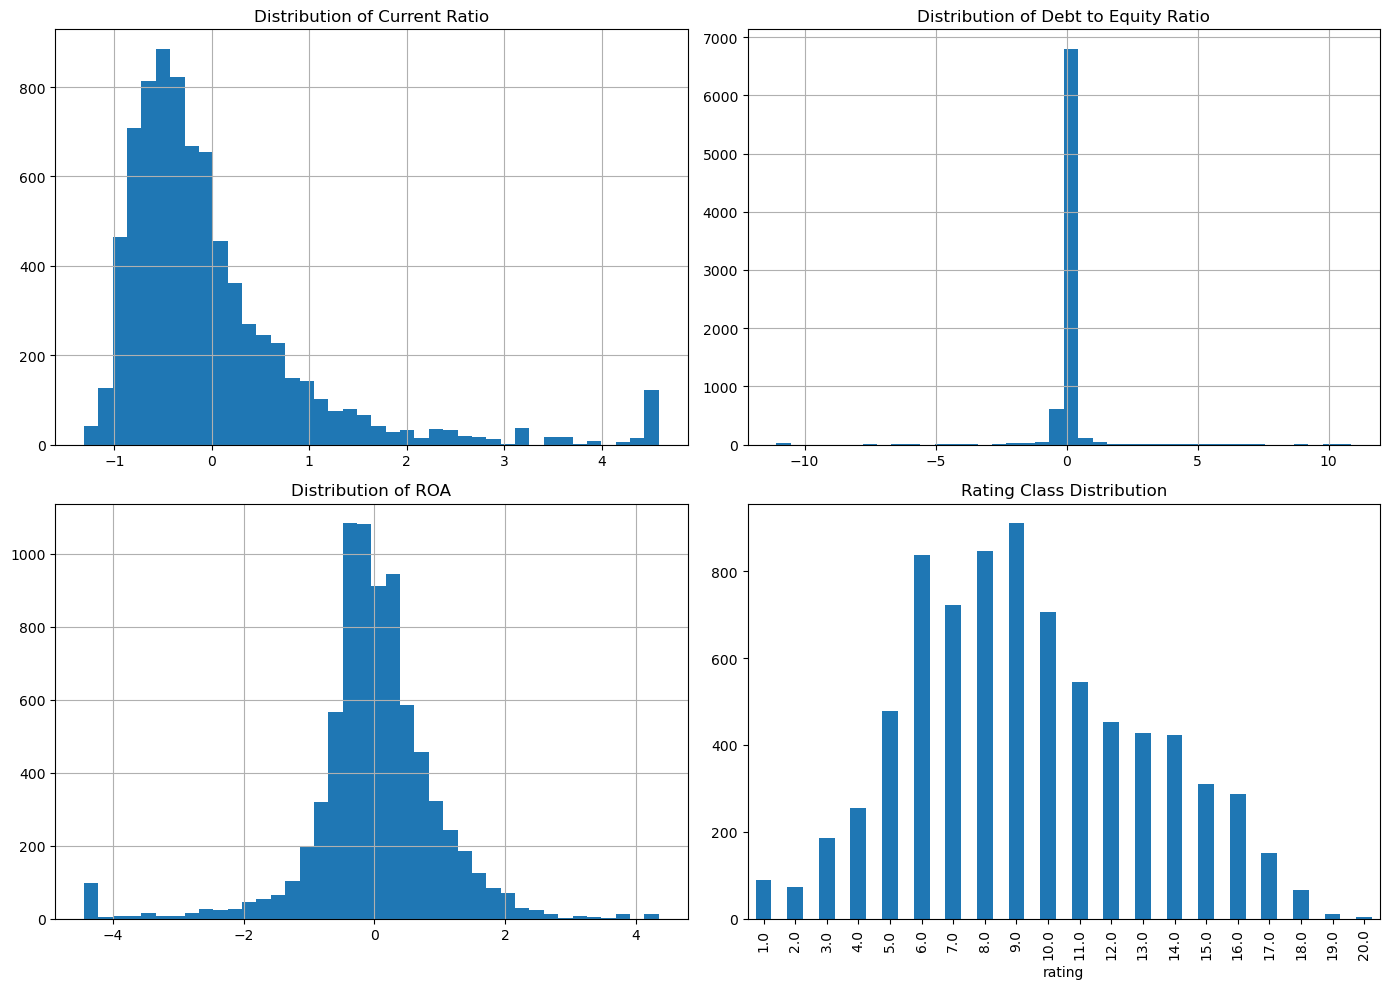

In [34]:
visual_after_code_writer = student_b

start_time_va = now()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

if "current_ratio" in cleaned_data.columns:
    cleaned_data["current_ratio"].hist(ax=axs[0, 0], bins=40)
    axs[0, 0].set_title("Distribution of Current Ratio")

if "debt_equity_ratio" in cleaned_data.columns:
    cleaned_data["debt_equity_ratio"].hist(ax=axs[0, 1], bins=40)
    axs[0, 1].set_title("Distribution of Debt to Equity Ratio")

if "roa___return_on_assets" in cleaned_data.columns:
    cleaned_data["roa___return_on_assets"].hist(ax=axs[1, 0], bins=40)
    axs[1, 0].set_title("Distribution of ROA")

if "rating" in cleaned_data.columns:
    cleaned_data["rating"].value_counts().sort_index().plot(kind="bar", ax=axs[1, 1])
    axs[1, 1].set_title("Rating Class Distribution")

plt.tight_layout()
plt.show()

end_time_va = now()

#############################################
# Documentation
#############################################

visual_after_comment = """
Produce histograms for selected financial ratios and a bar chart for rating classes.
The plots show that outliers have been removed.
"""

va_ass_uuid_executor = "aaeb7ab9-c9f1-4b99-a248-123a9bfc7ae7"
visual_after_executor_triples = [
    f':visual_exploration prov:qualifiedAssociation :{va_ass_uuid_executor} .',
    f':{va_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{va_ass_uuid_executor} rdf:type prov:Association .',
    f':{va_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(visual_after_executor_triples, prefixes=prefixes)

va_ass_uuid_writer = "64c6a0ef-5ce3-4ad0-9efb-123z5a03c400"
visual_after_activity = [
    ':visual_exploration_after_cleaning rdf:type prov:Activity .',
    ':visual_exploration_after_cleaning sc:isPartOf :data_understanding_phase .',
    ':visual_exploration_after_cleaning rdfs:comment \'Data Understanding\' .',
    f':visual_exploration_after_cleaning rdfs:comment """{visual_after_comment}""" .',
    f':visual_exploration_after_cleaning prov:startedAtTime "{start_time_va}"^^xsd:dateTime .',
    f':visual_exploration_after_cleaning prov:endedAtTime "{end_time_va}"^^xsd:dateTime .',
    ':visual_exploration_after_cleaning prov:used :data .',
    f':visual_exploration_after_cleaning prov:qualifiedAssociation :{va_ass_uuid_writer} .',
    f':{va_ass_uuid_writer} prov:agent :{visual_after_code_writer} .',
    f':{va_ass_uuid_writer} rdf:type prov:Association .',
    f':{va_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':visual_exploration_report rdf:type prov:Entity .',
    ':visual_exploration_report rdfs:label "Visual Exploration Summary" .',
    ':visual_exploration_report rdfs:comment """Histograms for key ratios and rating distribution.""" .',
    ':visual_exploration_report prov:wasGeneratedBy :visual_exploration .',
]
engine.insert(visual_after_activity, prefixes=prefixes)


In [35]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.
prepared_data = cleaned_data
prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data prov:wasGeneratedBy :data_preparation_phase .',
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_data sc:name "Prepared Corporate Credit Dataset" .',
    ':prepared_data sc:description "Final prepared dataset containing cleaned financial ratios and encoded credit rating targets for corporate credit risk modeling." .',
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [36]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [37]:
df = prepared_data.copy()

TARGET = "rating"
HELPER_TARGET = "binary_rating"

assert TARGET in df.columns, "Target column 'rating' missing in prepared_data"


In [38]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "773b57cd-2978-4347-8729-8791b73f7395"
dma_comment = """
We identify suitable algorithms for predicting the multi-class corporate credit rating from financial ratios.

Candidates:
1) Multinomial Logistic Regression (baseline)
   - Fast baseline for multi-class classification.
   - Works best if relations are close to linear.
   - Needs feature scaling.

2) Random Forest Classifier
   - Strong baseline for tabular numeric ratios.
   - Captures non-linear relations and feature interactions.
   - Robust with class_weight for imbalance.
   - Supports model interpretation via feature importance.

3) Histogram-based Gradient Boosting Classifier
   - Often strong on tabular data.
   - Captures non-linear effects.
   - Can outperform Random Forest with limited tuning.

Selection criterion:
We select the model with the best validation Macro F1 score.
Also report validation accuracy as a secondary metric.
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',

    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # algorithm definition
    f':logreg_algorithm rdf:type mls:Algorithm .',
    f':logreg_algorithm rdfs:label "Multinomial Logistic Regression" .',
    
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    f':hist_gradient_boosting_algorithm rdf:type mls:Algorithm .',
    f':hist_gradient_boosting_algorithm rdfs:label "Histogram-based Gradient Boosting Classifier" .',

    
    f':selected_model_implementation rdf:type mls:Model .',
    f':selected_model_implementation rdfs:label "Selected Model Implementation" .',
    f':selected_model_implementation prov:wasGeneratedBy :define_algorithm .',

    f':macro_f1_measure rdf:type mls:EvaluationMeasure .',
    f':macro_f1_measure rdfs:label "Macro F1" .',
    f':accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':accuracy_measure rdfs:label "Accuracy" .',
    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [39]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "e9848ebc-e283-49b2-9205-fb340f7bd05c"
hp_comment = """
We identify relevant hyperparameters for Random Forest.

Relevant hyperparameters:
- n_estimators: number of trees
- max_depth: maximum tree depth, controls model complexity and overfitting
- min_samples_split and min_samples_leaf: regularize splits
- max_features: number of features considered per split
- class_weight: handle class imbalance

Chosen tuning hyperparameter:
- max_depth
Reason:
- Direct control over overfitting and complexity.
- Simple grid search, easy to document and reproduce.

Fixed parameters for tuning:
- n_estimators = 300
- class_weight = balanced
- random_state = 42
"""

identify_hp_activity = [
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "n_estimators" .',
    f':hp_n_estimators rdfs:comment "Number of trees in the Random Forest." .',

    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "max_depth" .',
    f':hp_max_depth rdfs:comment "Maximum depth of each decision tree, controls complexity and overfitting." .',

    f':hp_min_samples_split rdf:type mls:HyperParameter .',
    f':hp_min_samples_split rdfs:label "min_samples_split" .',
    f':hp_min_samples_split rdfs:comment "Minimum number of samples required to split an internal node." .',

    f':hp_min_samples_leaf rdf:type mls:HyperParameter .',
    f':hp_min_samples_leaf rdfs:label "min_samples_leaf" .',
    f':hp_min_samples_leaf rdfs:comment "Minimum number of samples required to be at a leaf node." .',

    f':hp_max_features rdf:type mls:HyperParameter .',
    f':hp_max_features rdfs:label "max_features" .',
    f':hp_max_features rdfs:comment "Number of features considered when looking for the best split." .',

    f':hp_class_weight rdf:type mls:HyperParameter .',
    f':hp_class_weight rdfs:label "class_weight" .',
    f':hp_class_weight rdfs:comment "Weights associated with classes, used to handle class imbalance." .',

    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def split_data(df: pd.DataFrame):
    TARGET = "rating"
    assert TARGET in df.columns, "Target column 'rating' missing"

    d = df.copy()
    d = d.replace([np.inf, -np.inf], np.nan)
    d = d.dropna(subset=[TARGET]).copy()
    d[TARGET] = d[TARGET].astype(int)

    drop_cols = [TARGET]
    if "binary_rating" in d.columns:
        drop_cols.append("binary_rating")
    for c in ["ticker", "corporation", "sector", "rating_agency", "rating_date", "company"]:
        if c in d.columns:
            drop_cols.append(c)

    feature_df = d.drop(columns=drop_cols, errors="ignore")
    feature_df = feature_df.select_dtypes(include=["number"]).copy()

    modelling_df = pd.concat([feature_df, d[[TARGET]]], axis=1)
    modelling_df = modelling_df.dropna(axis=0).copy()

    X = modelling_df.drop(columns=[TARGET])
    y = modelling_df[TARGET].copy()

    min_per_class = 11
    class_counts = y.value_counts()
    keep_classes = class_counts[class_counts >= min_per_class].index
    X = X[y.isin(keep_classes)].copy()
    y = y[y.isin(keep_classes)].copy()

    assert y.nunique() > 1, "Need at least 2 classes after filtering"

    X_rest, X_test, y_rest, y_test = train_test_split(
        X, y,
        test_size=0.15,
        random_state=42,
        stratify=y
    )

    val_frac_of_rest = 0.15 / 0.85

    X_train, X_val, y_train, y_val = train_test_split(
        X_rest, y_rest,
        test_size=val_frac_of_rest,
        random_state=42,
        stratify=y_rest
    )

    return X_train, X_val, X_test, y_train, y_val, y_test



X_train, X_val, X_test, y_train, y_val, y_test = split_data(prepared_data)

n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)

print(n_train, n_val, n_test)
print("Classes:", y_train.nunique(), y_val.nunique(), y_test.nunique())
print("Min class count in train:", y_train.value_counts().min())
print("Min class count in val:", y_val.value_counts().min())
print("Min class count in test:", y_test.value_counts().min())


#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "6ad505bc-e815-4e92-94cd-8a8995a9bd6c"

min_per_class_used = 11
val_frac_of_rest = 0.15 / 0.85

split_comment = f"""
Train/Validation/Test split performed on prepared_data.

Pre-split cleaning and preparation:
- Replaced +/-inf with NaN globally.
- Dropped rows with missing target 'rating'.
- Kept numeric feature columns only.
- Dropped rows with missing numeric feature values.
- Filtered classes with fewer than {min_per_class_used} samples to ensure stable stratified splitting.

Split strategy:
- Step 1: Split off test set with test_size=0.15, stratified by 'rating', random_state=42.
- Step 2: Split the remaining 85% into training and validation.
  Validation fraction of remaining data: {val_frac_of_rest:.6f}, stratified by 'rating', random_state=42.
- Final ratio: 70% training, 15% validation, 15% test.

Resulting sizes:
- Training set: {n_train} samples
- Validation set: {n_val} samples
- Test set: {n_test} samples

Class distribution sanity check:
- Classes in train/val/test: {y_train.nunique()} / {y_val.nunique()} / {y_test.nunique()}
- Minimum class count in train: {int(y_train.value_counts().min())}
- Minimum class count in validation: {int(y_val.value_counts().min())}
- Minimum class count in test: {int(y_test.value_counts().min())}
"""

## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {n_train} samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {n_val} samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {n_test} samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

5432 1164 1164
Classes: 18 18 18
Min class count in train: 45
Min class count in val: 10
Min class count in test: 10


,max_depth,train_macro_f1,val_macro_f1,train_accuracy,val_accuracy
0,None,0.721837,0.455996,0.730854,0.439003
1,20,0.722082,0.455686,0.731038,0.438144
2,15,0.718941,0.450510,0.728277,0.434708
3,10,0.671826,0.430897,0.661451,0.410653
4,5,0.265987,0.195210,0.255891,0.193299


Selected best_depth: None
Best validation macro F1: 0.4559955029346403


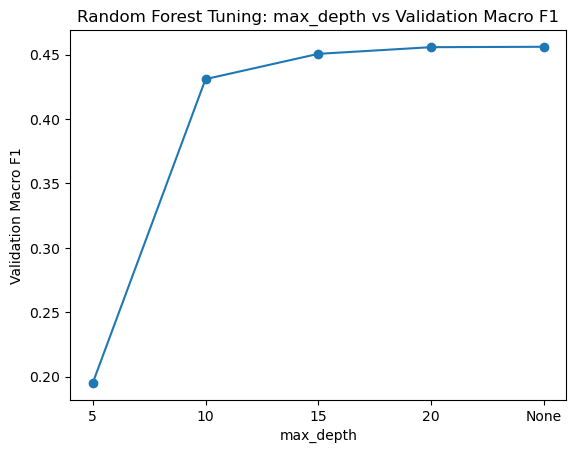

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

def train_and_finetune_model(X_train, y_train, X_val, y_val):
    depth_grid = [None, 5, 10, 15, 20]
    
    fixed_params = {
        "n_estimators": 300,
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    runs = []
    best_depth = None
    best_val_f1 = -1.0
    best_model = None

    for depth in depth_grid:
        model = RandomForestClassifier(max_depth=depth, **fixed_params)
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)

        train_f1 = f1_score(y_train, pred_train, average="macro")
        val_f1 = f1_score(y_val, pred_val, average="macro")

        train_acc = accuracy_score(y_train, pred_train)
        val_acc = accuracy_score(y_val, pred_val)

        runs.append({
            "max_depth": "None" if depth is None else int(depth),
            "train_macro_f1": float(train_f1),
            "val_macro_f1": float(val_f1),
            "train_accuracy": float(train_acc),
            "val_accuracy": float(val_acc),
        })

        if float(val_f1) > best_val_f1:
            best_val_f1 = float(val_f1)
            best_depth = depth
            best_model = model

    results_df = pd.DataFrame(runs).sort_values("val_macro_f1", ascending=False).reset_index(drop=True)
    return best_model, best_depth, best_val_f1, results_df
    
    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    


start_time_tafm = now()
best_model, best_depth, best_val_f1, tuning_results = train_and_finetune_model(
    X_train, y_train, X_val, y_val
)
end_time_tafm = now()

display(tuning_results)
print("Selected best_depth:", "None" if best_depth is None else best_depth)
print("Best validation macro F1:", best_val_f1)

plot_df = tuning_results.copy()

# map "None" to a large depth for ordering, then sort
plot_df["_depth_num"] = plot_df["max_depth"].apply(lambda x: 999 if str(x) == "None" else int(x))
plot_df = plot_df.sort_values("_depth_num", ascending=True)

plt.figure()
plt.plot(plot_df["max_depth"].astype(str), plot_df["val_macro_f1"], marker="o")
plt.xlabel("max_depth")
plt.ylabel("Validation Macro F1")
plt.title("Random Forest Tuning: max_depth vs Validation Macro F1")
plt.show()


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "a75da300-1e5a-4341-9de0-5bfaf753825a"

selected_depth_label = "None" if best_depth is None else str(best_depth)

tafm_comment = f"""
We trained and fine-tuned a Random Forest Classifier using the Train and Validation split created in 4c.
We performed a small grid search over max_depth to control model complexity.

Fixed hyperparameters:
- n_estimators = 300
- class_weight = balanced
- random_state = 42
- n_jobs = -1

Tuned hyperparameter:
- max_depth ∈ {list(tuning_results['max_depth'].astype(str).unique())}

Evaluation:
- Macro F1 and Accuracy on training and validation sets.

Selection:
- The final model is selected by highest validation Macro F1.
- Selected max_depth = {selected_depth_label}
- Best validation Macro F1 = {best_val_f1:.6f}
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',


    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f':macro_f1_measure rdf:type mls:EvaluationMeasure .',
    f':macro_f1_measure rdfs:label "Macro F1" .',

    f':accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':accuracy_measure rdfs:label "Accuracy" .',

    # Inputs
    f':train_and_finetune_model prov:used :training_set .',
    f':train_and_finetune_model prov:used :validation_set .',
]
engine.insert(train_model_activity, prefixes=prefixes)

for i, row in tuning_results.iterrows():
    run_idx = i + 1
    depth_label = str(row["max_depth"])

    training_run = f"rf_run_{run_idx}"
    model_entity = f"rf_model_{run_idx}"

    # Hyperparameter setting entity
    hp_setting = f"rf_hp_setting_{run_idx}_max_depth"

    # Evaluations: Macro F1 and Accuracy on Train and Val
    eval_train_f1 = f"rf_eval_{run_idx}_train_macro_f1"
    eval_val_f1 = f"rf_eval_{run_idx}_val_macro_f1"
    eval_train_acc = f"rf_eval_{run_idx}_train_accuracy"
    eval_val_acc = f"rf_eval_{run_idx}_val_accuracy"

    # Mark selected model/run
    is_selected = (depth_label == selected_depth_label)
    selected_tag = "SELECTED_MODEL" if is_selected else "NOT_SELECTED"

    triples = [
        ########################################
        # Parameter settings (HyperParameterSetting)
        f':{hp_setting} rdf:type mls:HyperParameterSetting .',
        f':{hp_setting} mls:specifiedBy :hp_max_depth .',
        f':{hp_setting} mls:hasValue "{depth_label}" .',
        f':{hp_setting} prov:wasGeneratedBy :train_and_finetune_model .',

        ########################################
        # Describe the Run (mls:Run)
        f':{training_run} rdf:type mls:Run .',
        f':{training_run} sc:isPartOf :train_and_finetune_model .',
        f':{training_run} mls:realizes :random_forest_algorithm .',
        f':{training_run} rdfs:label "RF Training Run {run_idx} (max_depth={depth_label})" .',

        # Inputs for this run
        f':{training_run} mls:hasInput :training_set .',
        f':{training_run} mls:hasInput :validation_set .',
        f':{training_run} mls:hasInput :{hp_setting} .',

        # Outputs for this run
        f':{training_run} mls:hasOutput :{model_entity} .',
        f':{training_run} mls:hasOutput :{eval_train_f1} .',
        f':{training_run} mls:hasOutput :{eval_val_f1} .',
        f':{training_run} mls:hasOutput :{eval_train_acc} .',
        f':{training_run} mls:hasOutput :{eval_val_acc} .',

        ########################################
        # Describe the Model (mls:Model)
        f':{model_entity} rdf:type mls:Model .',
        f':{model_entity} rdfs:label "Random Forest Model {run_idx}" .',
        f':{model_entity} prov:wasGeneratedBy :{training_run} .',
        f':{model_entity} mlso:trainedOn :training_set .',
        f':{model_entity} mlso:hasAlgorithmType :random_forest_algorithm .',
        f':{model_entity} rdfs:comment "{selected_tag}" .',

        ########################################
        # Evaluations (mls:ModelEvaluation)

        # Train Macro F1
        f':{eval_train_f1} rdf:type mls:ModelEvaluation .',
        f':{eval_train_f1} prov:wasGeneratedBy :{training_run} .',
        f':{eval_train_f1} mls:specifiedBy :macro_f1_measure .',
        f':{eval_train_f1} mls:hasValue "{row["train_macro_f1"]:.6f}"^^xsd:double .',
        f':{eval_train_f1} prov:used :training_set .',

        # Val Macro F1
        f':{eval_val_f1} rdf:type mls:ModelEvaluation .',
        f':{eval_val_f1} prov:wasGeneratedBy :{training_run} .',
        f':{eval_val_f1} mls:specifiedBy :macro_f1_measure .',
        f':{eval_val_f1} mls:hasValue "{row["val_macro_f1"]:.6f}"^^xsd:double .',
        f':{eval_val_f1} prov:used :validation_set .',

        # Train Accuracy
        f':{eval_train_acc} rdf:type mls:ModelEvaluation .',
        f':{eval_train_acc} prov:wasGeneratedBy :{training_run} .',
        f':{eval_train_acc} mls:specifiedBy :accuracy_measure .',
        f':{eval_train_acc} mls:hasValue "{row["train_accuracy"]:.6f}"^^xsd:double .',
        f':{eval_train_acc} prov:used :training_set .',

        # Val Accuracy
        f':{eval_val_acc} rdf:type mls:ModelEvaluation .',
        f':{eval_val_acc} prov:wasGeneratedBy :{training_run} .',
        f':{eval_val_acc} mls:specifiedBy :accuracy_measure .',
        f':{eval_val_acc} mls:hasValue "{row["val_accuracy"]:.6f}"^^xsd:double .',
        f':{eval_val_acc} prov:used :validation_set .',
    ]

    engine.insert(triples, prefixes=prefixes)

# Visualization entity (4e)
viz_comment = "Random Forest tuning curve showing Validation Macro F1 for different max_depth values."
engine.insert([
    f':rf_tuning_figure rdf:type sc:Visualization .',
    f':rf_tuning_figure rdfs:label "RF Tuning Curve" .',
    f':rf_tuning_figure rdfs:comment "{viz_comment}" .',
    f':rf_tuning_figure prov:wasGeneratedBy :train_and_finetune_model .',
], prefixes=prefixes)






In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd

def retrain_model_full_data(X_train, y_train, X_val, y_val, best_depth):
    X_full = pd.concat([X_train, X_val], axis=0)
    y_full = pd.concat([y_train, y_val], axis=0)

    fixed_params = {
        "n_estimators": 300,
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    final_model = RandomForestClassifier(max_depth=best_depth, **fixed_params)
    final_model.fit(X_full, y_full)
    return final_model, X_full, y_full


start_time_tafm = now()
final_model_obj, X_full, y_full = retrain_model_full_data(
    X_train, y_train, X_val, y_val, best_depth
)
end_time_tafm = now() 

print("Final model trained on train+validation")
print("max_depth:", "None" if best_depth is None else best_depth)
print("Full training size:", len(X_full))
print("Classes in full training:", y_full.nunique())

#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "89880614-d9d2-4207-a197-441a4e8a156e" # Generate once

final_training_activity = ":retrain_final_model"
final_model_entity = ":final_model_entity"
full_train_dataset = ":training_validation_set"

selected_depth_label = "None" if best_depth is None else str(best_depth)

start_time_retrain = start_time_tafm
end_time_retrain = end_time_tafm

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_comment = f"""
Final retraining step (4g) after hyperparameter tuning and model selection (4d-4f).

Goal:
- Train the final model on all available labeled data excluding the test set.

Training data:
- Combined training_set and validation_set (from 4c) into one dataset.

Algorithm:
- Random Forest Classifier

Hyperparameters:
- max_depth = {selected_depth_label} (selected in 4f)
- n_estimators = 300
- class_weight = balanced
- random_state = 42
- n_jobs = -1

Full training size (train+validation):
- {len(X_full)} samples
- {y_full.nunique()} classes
"""

retrain_documentation = [
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',

    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',

    f'{full_train_dataset} rdf:type sc:Dataset .',
    f'{full_train_dataset} rdfs:label "Training+Validation Set" .',
    f'{full_train_dataset} prov:wasGeneratedBy {final_training_activity} .',
    f'{full_train_dataset} prov:wasDerivedFrom :training_set .',
    f'{full_train_dataset} prov:wasDerivedFrom :validation_set .',
    f'{full_train_dataset} rdfs:comment "Contains {len(X_full)} samples (combined from training and validation)." .',

    f':final_hp_setting_max_depth rdf:type mls:HyperParameterSetting .',
    f':final_hp_setting_max_depth mls:specifiedBy :hp_max_depth .',
    f':final_hp_setting_max_depth mls:hasValue "{selected_depth_label}" .',
    f':final_hp_setting_max_depth prov:wasGeneratedBy {final_training_activity} .',

    f':final_training_run rdf:type mls:Run .',
    f':final_training_run sc:isPartOf {final_training_activity} .',
    f':final_training_run mls:realizes :random_forest_algorithm .',
    f':final_training_run rdfs:label "Final RF training run on train+validation (max_depth={selected_depth_label})" .',
    f':final_training_run mls:hasInput {full_train_dataset} .',
    f':final_training_run mls:hasInput :final_hp_setting_max_depth .',
    f':final_training_run mls:hasOutput {final_model_entity} .',

    f'{final_model_entity} rdf:type mls:Model .',
    f'{final_model_entity} rdfs:label "Final Random Forest Model" .',
    f'{final_model_entity} prov:wasGeneratedBy :final_training_run .',
    f'{final_model_entity} mlso:trainedOn {full_train_dataset} .',
    f'{final_model_entity} mlso:hasAlgorithmType :random_forest_algorithm .',
    f'{final_model_entity} rdfs:comment "Final model trained with max_depth={selected_depth_label}, n_estimators=300, class_weight=balanced, random_state=42." .',

    
    
]
engine.insert(retrain_documentation, prefixes=prefixes)


Final model trained on train+validation
max_depth: None
Full training size: 6596
Classes in full training: 18


## Evaluation

In [43]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

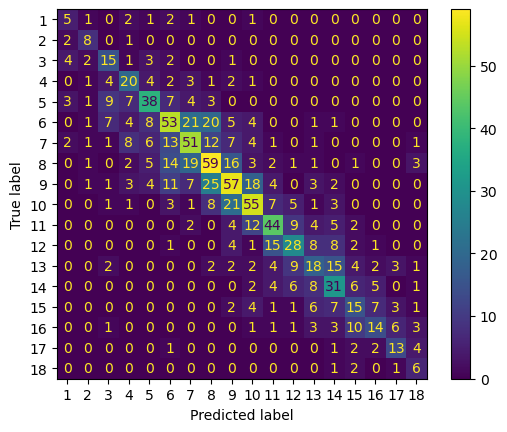

f1: 0.4471
accuracy: 0.4553
precision: 0.4345
recall: 0.4740
mae: 1.1529
qwk: 0.8622
plusMinus1Accuracy: 0.7191
   SIC_Group  Samples  Accuracy       MAE  PlusMinus1  DirectionalBias
6          7       98  0.540816  0.857143    0.765306        -0.122449
5          6       35  0.571429  0.914286    0.800000        -0.114286
1          2      235  0.451064  1.097872    0.723404        -0.059574
2          3      275  0.472727  1.127273    0.749091        -0.283636
4          5      102  0.421569  1.147059    0.686275        -0.303922
3          4      236  0.449153  1.271186    0.728814         0.050847
0          1      145  0.420690  1.282759    0.634483         0.027586
7          8       33  0.272727  1.303030    0.666667        -0.212121
8          9        5  0.400000  2.400000    0.400000         1.600000


In [44]:
eval_code_writer = student_b
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, cohen_kappa_score, precision_score, recall_score
def evaluate_on_test_data(final_model, test_set):
    # Predict and evaluation on test data
    X_test = test_set[0]
    y_test = test_set[1]
    pred_test = final_model.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
    plt.show()

    return  {
        "f1": f1_score(y_test, pred_test, average="macro"),
        "accuracy": accuracy_score(y_test, pred_test),
        "precision": precision_score(y_test, pred_test, average="macro"),
        "recall": recall_score(y_test, pred_test, average="macro"),
        "mae": mean_absolute_error(y_test, pred_test),
        "qwk": cohen_kappa_score(y_test, pred_test, weights="quadratic"),
        "plusMinus1Accuracy": np.mean(np.abs(y_test - pred_test) <= 1)
    }
def evaluate_bias_by_sic(test_set,model):
    X_test = test_set[0]
    y_test = test_set[1]
    sic_col_idx = 1
    rows = []

    sic_codes = X_test.iloc[:, sic_col_idx].astype(int)
    sic_groups = sic_codes // 1000  # 1-digit SIC

    for sic_group in np.unique(sic_groups):
        mask = sic_groups == sic_group

        #if mask.sum() < min_samples:
         #   continue

        X_s = X_test[mask]
        y_true = y_test[mask]
        y_pred = model.predict(X_s)

        rows.append({
            "SIC_Group": sic_group,
            "Samples": mask.sum(),
            "Accuracy": accuracy_score(y_true, y_pred),
            "MAE": mean_absolute_error(y_true, y_pred),
            "PlusMinus1": np.mean(np.abs(y_true - y_pred) <= 1),
            "DirectionalBias": np.mean(y_pred - y_true)
        })

    return pd.DataFrame(rows).sort_values("MAE")
    
test_set = [X_test, y_test]

start_time_eval = now()
metrics = evaluate_on_test_data(final_model_obj, test_set)
bias_eval = evaluate_bias_by_sic(test_set, final_model_obj)
end_time_eval = now() 

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")
print(bias_eval)


#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1631e9-feed-87za-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 
eval_comment = """ 
In this part we evaluate our model. We look at the performance,compare it to state of the art and random classifiers and at at bias. 
"""
performance_comment = """
To evaluate the performance of our model we have to look at different metrics. The accuracy of our model is only 0.4553 
this means only 45% of the classifications are correct. But this can be explained. We have 18 different classes and these classes are ordinal. 
A wrong classification is not so bad if it is not far away from the correct class. So we have to look at the distances. 
One way to do this is to look how many classifications have a distance of 1 or less, so the are in the right or in one of the neighboring classes.
In this case our accuracy is 0.7191 which means nearly 72 percent of our classification do have a maximum distance of 1 from the right class. 
Other measures to look at are the Mean Absolute Error (MAE) and Quadratic Weighted Kappa (QWK). 
The Mean Absolute Error is the average of the distances. For our model the mea is 1.15, this means on average the classification is 1.15 classes away from the true class.
For a model with 18 classes this is quite ok and a rather small error.
Quadratic Weighted Kappa measures the agreement between predictions and truth and penalizes big mistakes quadratically. This means if the prediction is very wrong 
it is weighted higher than if it is only slightly wrong. For our model qwk is 0.86 which is very good, 1 would be perfect. 

f1: 0.4471
accuracy: 0.4553
precision: 0.4345
recall: 0.4740
mae: 1.1529
qwk: 0.8622
plusMinus1: 0.7191

Makwana, R., Bhatt, D., Delwadia, K. et al. Understanding and Attaining an Investment Grade Rating in the Age of Explainable AI. Comput Econ 66, 105–126 (2025). https://doi.org/10.1007/s10614-024-10700-7
showed with the same dataset that the could reach a accuracy of 0.80. That is higher than our accuracy. The difference from their approach to ours
is that they only used 9 features instead of the 18 features we used. This is most likely the reason for the difference in performance.

The performance of a random classifier would be 1/18 because we have 18 classes. This results in 0,055 so 5,5% would be correctly classified. Our model is much better

The success criteria we defined in the beginning: 
-) Achieve a macro-averaged F1 score of at least 0.7 on the test set.
-) Achieve at least a recall of 0.75 for the lowest rating classes.
-) Keep the difference between validation and test F1 below 0.05.
-) Maintain accuracy for all classes rated above 0.60 where sample size is sufficient.
The only criteria where we are successful is 'Keep the difference between validation and test F1 below 0.05.' F1 for validation set is 0.45 and for test 0.4471
so not even 1 percent difference. The other criteria are not fulfilled for reasons talked about before. 
"""
bias_comment = """
We have not protected attribute like gender, race, age in our dataset. So we will use the attribute sic code as protected attribute, 
so we can test if there is a bias towards it. The sic code is a code which shows what main business are a company has. 

The results show that model performance varies between industries. Some SIC groups achieve
higher accuracy and lower mean absolute error, while others show larger
prediction errors.

The directional bias is near zero for most SIC groups, indicating
that the model does not systematically over- or under-rate companies.
One group shows a large directional bias, but this group contains only
very few samples and is therefore not reliable. Overall, the observed
differences indicate performance similar across industries and not a discriminatory bias.

SIC_Group  Samples  Accuracy       MAE  PlusMinus1  DirectionalBias
6          7       98  0.540816  0.857143    0.765306        -0.122449
5          6       35  0.571429  0.914286    0.800000        -0.114286
1          2      235  0.451064  1.097872    0.723404        -0.059574
2          3      275  0.472727  1.127273    0.749091        -0.283636
4          5      102  0.421569  1.147059    0.686275        -0.303922
3          4      236  0.449153  1.271186    0.728814         0.050847
0          1      145  0.420690  1.282759    0.634483         0.027586
7          8       33  0.272727  1.303030    0.666667        -0.212121
8          9        5  0.400000  2.400000    0.400000         1.600000
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
    f':model_performance_result rdf:type mls:ModelEvaluation .',
    f':model_performance_result prov:wasGeneratedBy :evaluate_final_model .',
    f':model_performance_result rdfs:label "Model performance" .',
    f':model_performance_result rdfs:comment """{performance_comment}""" .',
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment """{bias_comment}""" .',

]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [45]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [46]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
The developed credit rating model shows mixed performance when compared to the predefined business success 
and data mining success criteria. While the overall classification accuracy (0.46) and macro-averaged F1 score (0.45) 
fall short of the strict data mining success targets, the ordinal performance metrics indicate that the model still provides 
substantial decision support value in the business context.
The requirement of achieving a macro-averaged F1 score of at least 0.7 on the test set is not met. Similarly, the recall for 
the lowest rating classes does not reach the target value of 0.75. These results indicate that the model is not yet suitable 
as a fully automated decision-making system, particularly for high-risk companies where misclassification could lead to financial losses. 
In addition, the gap between validation and test performance cannot be fully assessed due to missing validation metrics, limiting conclusions 
about generalization stability.
However, other metrics provide a more favorable picture with respect to the business objectives. The model achieves a Quadratic 
Weighted Kappa of 0.86 and a ±1 notch accuracy of approximately 72%. This indicates strong ordinal agreement between predicted 
and true ratings, meaning that most errors are small and close to the correct rating class. For a problem with 18 ordered rating 
classes, a mean absolute error of 1.15 rating notches is relatively low and suggests that the model captures the overall risk 
structure well.
From a business perspective, these results are sufficient to support analysts rather than replace them. The model can help 
reduce inconsistencies between analysts by providing a consistent baseline rating suggestion, especially for low- and medium-risk companies. 
This supports the objective of reducing manual review effort and speeding up rating decisions for new credit applications. However, 
the current performance is not sufficient to safely automate accept/reject decisions for high-risk companies, as the recall for 
the lowest rating classes remains below the required threshold.
"""

ethical_aspects_comment = """
The use of a machine learning model for corporate credit rating raises several ethical and risk-related concerns. 
As discussed in the AI risk assessment, historical credit ratings may already contain human bias, which the model 
can inherit and reinforce. In addition, incorrect predictions for low-rated companies pose a financial risk, while 
overly conservative predictions for high-quality companies may lead to lost business and reputational damage. The 
risk of concept drift is also relevant, as changing economic conditions can reduce model reliability over time if not properly monitored.

The bias analysis using SIC codes shows that model performance varies across industry groups, with some sectors 
exhibiting higher prediction errors than others. Although no strong systematic directional bias was observed for 
most groups, this uneven performance may still disadvantage certain industries if the model is used without safeguards. 
To mitigate these risks, the model should be deployed as a decision-support system with human oversight, particularly 
for high-risk cases, and its performance should be regularly monitored across industries and over time.
"""

monitoring_plan_comment = """
During deployment, several aspects of the credit rating model must be continuously monitored to ensure reliable and 
responsible operation. First, model performance metrics such as accuracy, mean absolute error (MAE), and +/-1-notch 
accuracy should be tracked over time. A significant deterioration in these metrics, for example an increase in MAE 
above 1.5 or a decrase in  +/-1-notch accuracy below 60%, should trigger model review or retraining. In particular, recall 
for the lowest rating classes must be monitored closely, as declining performance in this area increases the risk of 
incorrectly accepting high-risk companies.

Second, data and distributional changes should be monitored to detect concept drift. Shifts in the distribution of 
financial ratios or rating predictions compared to the training data indicate changing economic conditions and may 
invalidate the model. Additionally, fairness across industries, monitored using SIC-based performance metrics, should 
be reviewed regularly. A sustained increase in error or directional bias for specific SIC groups should trigger further 
investigation and potential model adjustment. Finally, human override rates and analyst feedback should be monitored; a 
sharp increase in overrides is a strong signal that the model’s recommendations are no longer aligned with expert judgment 
and require intervention.
"""

reproducibility_reflection_comment = """
The project documents the data source, use case, modeling approach, and evaluation metrics clearly, which supports reproducibility 
at a conceptual level. The use of standard libraries and well-defined performance measures further helps ensure that the overall 
workflow can be understood and repeated.

However, full reproducibility is limited by missing details such as exact preprocessing steps, hyperparameter settings, random 
seeds, and fixed dataset versions. Without this information, re-running the analysis may lead to slightly different results. 
Providing more detailed configuration and experiment tracking would further improve reproducibility.
"""

dep_ass_uuid_executor = "99a911e0-1994-4567-89ab-cdef01734567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [47]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [48]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [49]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

HTTPError: HTTP Error 504: Gateway Time-out

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")